### Data

We will repeat datasets preparation as it was in the previous notebook.

In [92]:
import pandas as pd
import tensorflow as tf
df = pd.read_csv('IMDB_larger_description_dataset.csv')
one_hot_genres = pd.get_dummies(df['genre'])
genre_totals = one_hot_genres.sum()
X=list(df['description'])
y = pd.get_dummies(df['genre']).values.tolist()
genre_mapping = pd.get_dummies(df['genre']).columns.tolist()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)

from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_labels = tf.convert_to_tensor(y_train, dtype=tf.float32)
val_labels = tf.convert_to_tensor(y_val, dtype=tf.float32)

# Data Preparation - Creating tf datasets

# 1 - get text
train_data = [{'text': text} for text in X_train]
val_data = [{'text': text} for text in X_val]

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# 2 - fetched text present in the tokenized way
train_dataset = list(map(tokenize_function, train_data))
val_dataset = list(map(tokenize_function, val_data))

# 3 - converting columns to tensors
train_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in train_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in train_dataset])
}

val_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in val_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in val_dataset])
}

# 4 - combining all together to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(16)

train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### L2 = 0.01, Early Stopping patience = 3, LR = 1e-5. Accuracy -> 0.72

In [35]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

In [37]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [39]:
regularizer = tf.keras.regularizers.l2(l=0.01)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

In [40]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [41]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback]
)

Epoch 1/10
80/80 [==============================] - 400s 5s/step - loss: 1.3416 - accuracy: 0.3656 - val_loss: 1.1774 - val_accuracy: 0.6771
Epoch 2/10
80/80 [==============================] - 514s 6s/step - loss: 0.9841 - accuracy: 0.6828 - val_loss: 0.8342 - val_accuracy: 0.6979
Epoch 3/10
80/80 [==============================] - 625s 8s/step - loss: 0.6479 - accuracy: 0.8188 - val_loss: 0.7655 - val_accuracy: 0.6771
Epoch 4/10
80/80 [==============================] - 671s 8s/step - loss: 0.4509 - accuracy: 0.8703 - val_loss: 0.7056 - val_accuracy: 0.6771
Epoch 5/10
80/80 [==============================] - 588s 7s/step - loss: 0.3171 - accuracy: 0.9031 - val_loss: 0.7034 - val_accuracy: 0.6927
Epoch 6/10
80/80 [==============================] - 586s 7s/step - loss: 0.2105 - accuracy: 0.9469 - val_loss: 0.7052 - val_accuracy: 0.7500
Epoch 7/10
80/80 [==============================] - 454s 6s/step - loss: 0.1276 - accuracy: 0.9828 - val_loss: 0.7504 - val_accuracy: 0.7396
Epoch 8/10
80

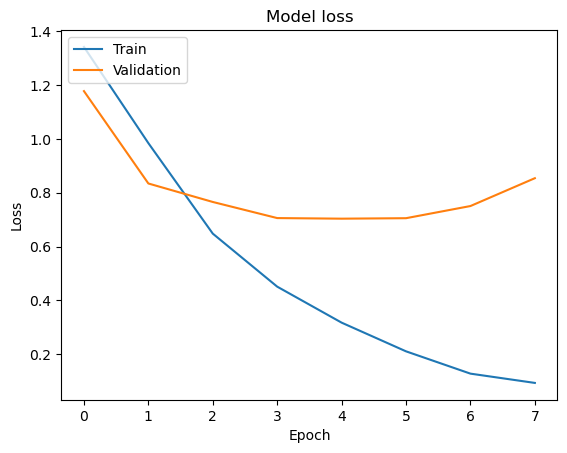

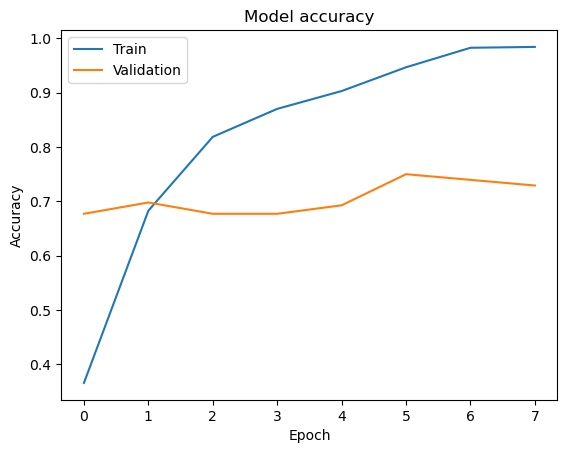

In [49]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [53]:
model.evaluate(test_dataset)

13/13 [==============================] - 26s 2s/step - loss: 0.6321 - accuracy: 0.7200


[0.6321067810058594, 0.7200000286102295]

**Model Loss:** <br>
- The training loss consistently decreases, which indicates that the model is learning from the training data. <br>
- The validation loss initially decreases but then levels off and begins to slightly increase, indicating **potential overfitting starting around the 3rd or 4th epoch.** <br>

**Model Accuracy:** <br>
- The training accuracy consistently increases, showing that the model is fitting better on the training data.<br>
- The validation accuracy peaks around the 2nd epoch and then remains relatively flat with some minor fluctuations, which again suggests that the model might be **overfitting** after the initial few epochs.

### L2 = 0.01, Early Stopping patience = 3, LR = 1e-5. + reduce_lr, + dropout=0.3 Accuracy -> 0.73

In [10]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.3, attention_dropout=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
regularizer = tf.keras.regularizers.l2(l=0.01)
for layer in model2.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [12]:
history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 320s 4s/step - loss: 1.3544 - accuracy: 0.3672 - val_loss: 1.2388 - val_accuracy: 0.6146 - lr: 1.0000e-05
Epoch 2/10
80/80 [==============================] - 391s 5s/step - loss: 1.0761 - accuracy: 0.6391 - val_loss: 0.9237 - val_accuracy: 0.6302 - lr: 1.0000e-05
Epoch 3/10
80/80 [==============================] - 416s 5s/step - loss: 0.7920 - accuracy: 0.7563 - val_loss: 0.7796 - val_accuracy: 0.6771 - lr: 1.0000e-05
Epoch 4/10
80/80 [==============================] - 408s 5s/step - loss: 0.5941 - accuracy: 0.8266 - val_loss: 0.7003 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 5/10
80/80 [==============================] - 427s 5s/step - loss: 0.4557 - accuracy: 0.8469 - val_loss: 0.7234 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 6/10
80/80 [==============================] - 433s 5s/step - loss: 0.3730 - accuracy: 0.8719 - val_loss: 0.7873 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 7/10
80/80 [==============================] - 

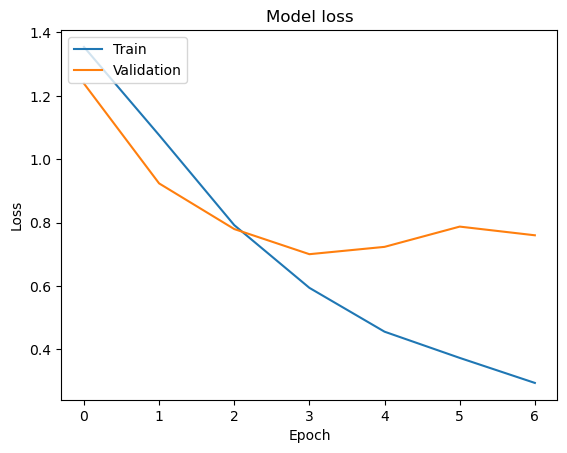

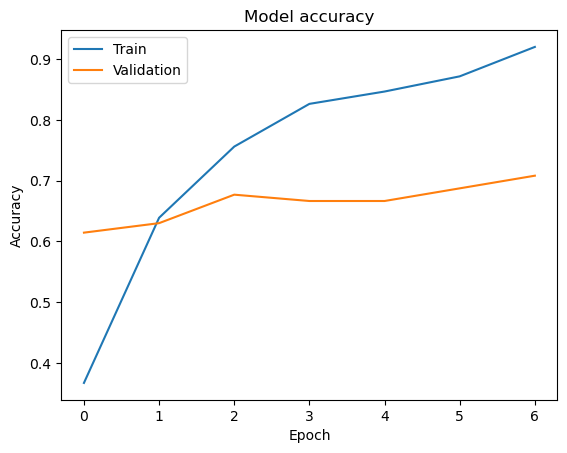

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [18]:
model2.evaluate(test_dataset)

13/13 [==============================] - 27s 2s/step - loss: 0.6544 - accuracy: 0.7300


[0.6543944478034973, 0.7300000190734863]

**Model Loss:** <br>
- The training loss continues to decrease, indicating consistent learning from the training data.
- The validation loss curve shows a slight increase after around the 3rd epoch but seems to stabilize somewhat afterward.

**Model Accuracy:** <br>
- The training accuracy continues to improve and reaches a high level, indicating that the model is well-fitted to the training data.
- The validation accuracy shows slight improvement compared to the previous run (from 0.72 to 0.73). This indicates that the learning rate reduction strategy may have helped the model improve its performance on the validation set, albeit slightly.

### L2 = 0.05, Early Stopping patience = 2, LR = 3e-5. + reduce_lr, + dropout=0.3 Accuracy -> 0.75

In [21]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification
model3 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.3, attention_dropout=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) # slightly higher lr - if that stabilizes the validation performance
regularizer = tf.keras.regularizers.l2(l=0.05) # slightly higher regularization - if it helps reduce overfitting further
for layer in model3.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
# A lower patience might help stop training before the validation performance begins to worsen significantly.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 314s 4s/step - loss: 1.2076 - accuracy: 0.4766 - val_loss: 0.9779 - val_accuracy: 0.6146 - lr: 3.0000e-05
Epoch 2/10
80/80 [==============================] - 359s 5s/step - loss: 0.7008 - accuracy: 0.7641 - val_loss: 0.8107 - val_accuracy: 0.6562 - lr: 3.0000e-05
Epoch 3/10
80/80 [==============================] - 374s 5s/step - loss: 0.4178 - accuracy: 0.8531 - val_loss: 0.8986 - val_accuracy: 0.6615 - lr: 3.0000e-05
Epoch 4/10
80/80 [==============================] - 394s 5s/step - loss: 0.3113 - accuracy: 0.9078 - val_loss: 1.1620 - val_accuracy: 0.6354 - lr: 3.0000e-05


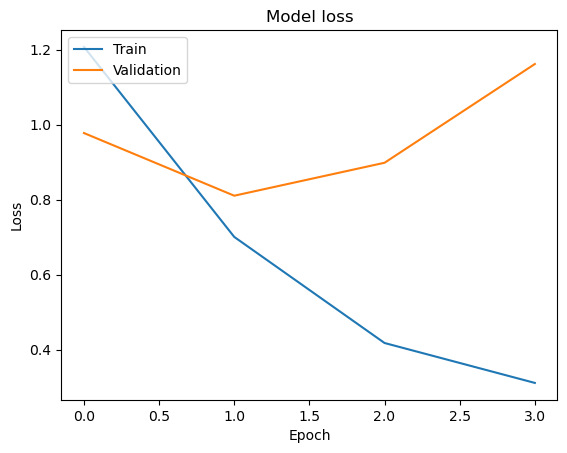

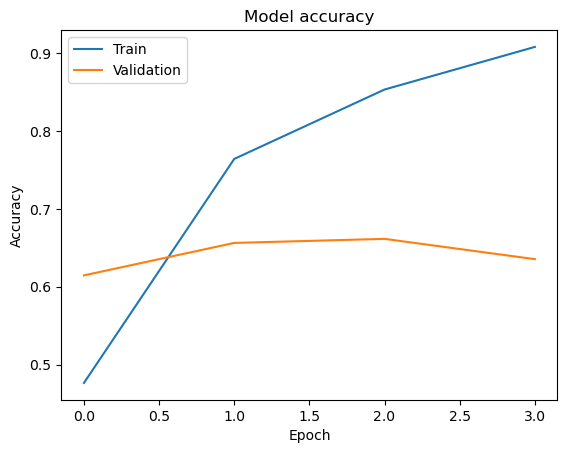

In [25]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [29]:
model3.evaluate(test_dataset)

13/13 [==============================] - 26s 2s/step - loss: 0.6751 - accuracy: 0.7500


[0.6750826239585876, 0.75]

**Model Loss:** <br>
- The training loss continues to decrease significantly, showing effective learning from the training data.
- The validation loss decreases initially but begins to increase after the 2nd epoch. This increase in validation loss while the training loss continues to decrease is a sign of overfitting. However, this overfitting seems to occur slightly later, likely due to the higher regularization (L2 = 0.05) and adjusted learning rate.
  
**Model Accuracy:** <br>
- The training accuracy steadily increases, indicating that the model is fitting the training data well.
- The validation accuracy improves to 0.75, which is better than previous attempts. However, the slight drop after the 2nd epoch could be due to overfitting, reinforced by the increase in validation loss.

### L2 = 0.06, Early Stopping patience = 2, LR = 3e-5. + reduce_lr, dropout=0.4 Accuracy -> 0.74

In [32]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

#  if it helps further reduce overfitting
model4 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.4, attention_dropout=0.4) 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

regularizer = tf.keras.regularizers.l2(l=0.06) # experimenting in the range 0.1-0.05
for layer in model4.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
            
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model4.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [34]:
history4 = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 326s 4s/step - loss: 1.2831 - accuracy: 0.3828 - val_loss: 1.0786 - val_accuracy: 0.5521 - lr: 3.0000e-05
Epoch 2/10
80/80 [==============================] - 375s 5s/step - loss: 0.8501 - accuracy: 0.6828 - val_loss: 0.7968 - val_accuracy: 0.6354 - lr: 3.0000e-05
Epoch 3/10
80/80 [==============================] - 388s 5s/step - loss: 0.5826 - accuracy: 0.7828 - val_loss: 0.8144 - val_accuracy: 0.6615 - lr: 3.0000e-05
Epoch 4/10
80/80 [==============================] - 396s 5s/step - loss: 0.4280 - accuracy: 0.8453 - val_loss: 0.8169 - val_accuracy: 0.6875 - lr: 3.0000e-05


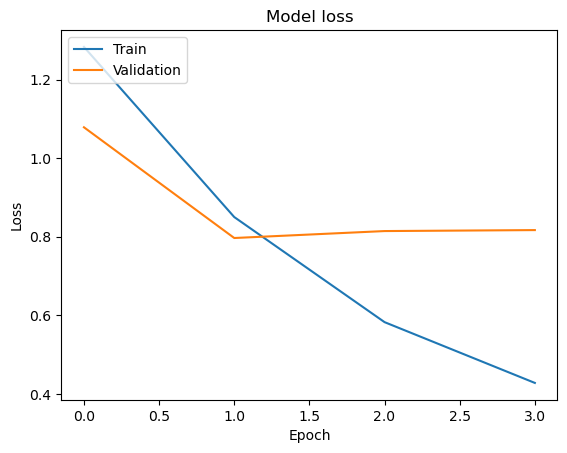

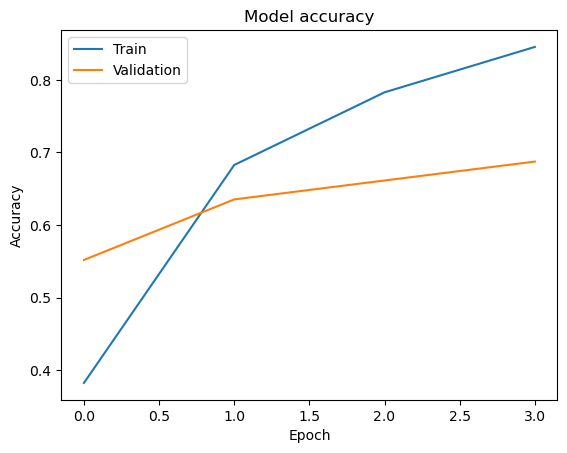

In [35]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [37]:
model4.evaluate(test_dataset)

13/13 [==============================] - 38s 3s/step - loss: 0.6807 - accuracy: 0.7400


[0.680672287940979, 0.7400000095367432]

**Model Loss:** <br>
- The training loss continues to decrease as expected, indicating effective learning.
- The validation loss shows an initial decrease followed by stabilization, with a slight upward trend toward the end. This could be due to the model overfitting slightly after a certain point, despite the increased regularization and dropout.

**Model Accuracy:** <br>
- Training accuracy continues to rise, which is consistent with previous runs.
- Validation accuracy has slightly decreased to 0.74 from the previous 0.75. Dropout can reduce overfitting by preventing the model from becoming too reliant on specific neurons, but it can also lower accuracy slightly as it makes the model less powerful during training.

### L2 = 0.05, Early Stopping patience = 2, LR = 3e-5. + reduce_lr, dropout=0.4 Accuracy -> 0.7050

In [44]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

#  if it helps further reduce overfitting
model5 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.4, attention_dropout=0.4) 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

regularizer = tf.keras.regularizers.l2(l=0.05) # returning to 0.05
for layer in model5.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
            
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [46]:
history5 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 530s 7s/step - loss: 1.3178 - accuracy: 0.3594 - val_loss: 1.2079 - val_accuracy: 0.4271 - lr: 3.0000e-05
Epoch 2/10
80/80 [==============================] - 602s 8s/step - loss: 0.9091 - accuracy: 0.6641 - val_loss: 0.8549 - val_accuracy: 0.6250 - lr: 3.0000e-05
Epoch 3/10
80/80 [==============================] - 663s 8s/step - loss: 0.6268 - accuracy: 0.7859 - val_loss: 0.8571 - val_accuracy: 0.6302 - lr: 3.0000e-05
Epoch 4/10
80/80 [==============================] - 631s 8s/step - loss: 0.4407 - accuracy: 0.8406 - val_loss: 1.0702 - val_accuracy: 0.6458 - lr: 3.0000e-05


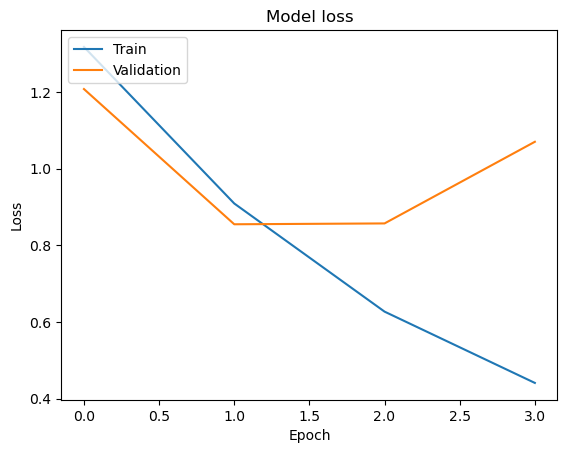

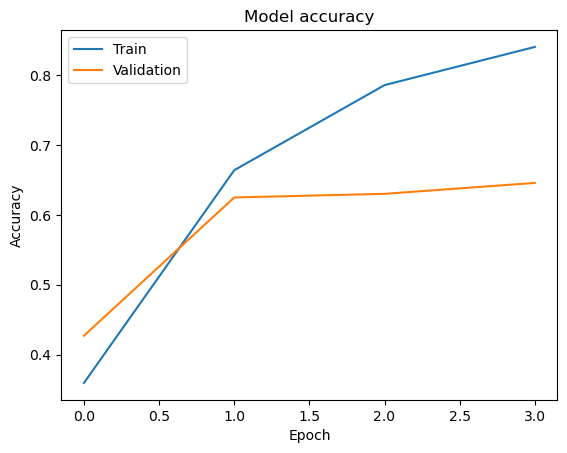

In [47]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [49]:
model5.evaluate(test_dataset)

13/13 [==============================] - 59s 5s/step - loss: 0.7689 - accuracy: 0.7050


[0.7689371705055237, 0.7049999833106995]

**Model Loss:** <br>
- The training loss continues to decrease steadily, indicating that the model is effectively learning from the training data.
- The validation loss initially decreases but then starts to increase again around the 2nd epoch, suggesting that the model is overfitting to the training data despite the use of dropout and L2 regularization.

**Model Accuracy:** <br>
- The training accuracy continues to rise, as expected, given the decreasing training loss.
- The validation accuracy has dropped to 0.705, indicating a decrease in performance compared to the previous iteration (0.74). This drop might be due to the adjustments in regularization and the effects of dropout.

### L2 = 0.06, Early Stopping patience = 2, LR = 3e-5. + reduce_lr, dropout=0.35 Accuracy -> 0.76

In [55]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

#  if it helps further reduce overfitting
model6 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.35, attention_dropout=0.35)  # adjust to 0.35 from 0.4
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

regularizer = tf.keras.regularizers.l2(l=0.06) # returning to 0.06
for layer in model6.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
            
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model6.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [57]:
history6 = model6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 335s 4s/step - loss: 1.1942 - accuracy: 0.4875 - val_loss: 1.2958 - val_accuracy: 0.4062 - lr: 3.0000e-05
Epoch 2/10
80/80 [==============================] - 380s 5s/step - loss: 0.8052 - accuracy: 0.7125 - val_loss: 0.8273 - val_accuracy: 0.6458 - lr: 3.0000e-05
Epoch 3/10
80/80 [==============================] - 372s 5s/step - loss: 0.5152 - accuracy: 0.8203 - val_loss: 0.7494 - val_accuracy: 0.6979 - lr: 3.0000e-05
Epoch 4/10
80/80 [==============================] - 394s 5s/step - loss: 0.3895 - accuracy: 0.8656 - val_loss: 0.8500 - val_accuracy: 0.6823 - lr: 3.0000e-05
Epoch 5/10
80/80 [==============================] - 400s 5s/step - loss: 0.3073 - accuracy: 0.9031 - val_loss: 1.0053 - val_accuracy: 0.6875 - lr: 3.0000e-05


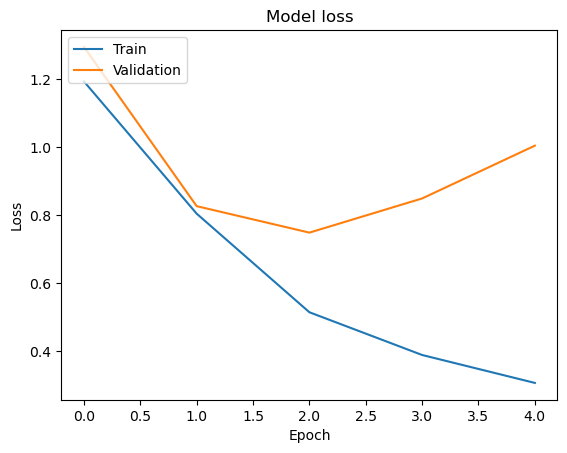

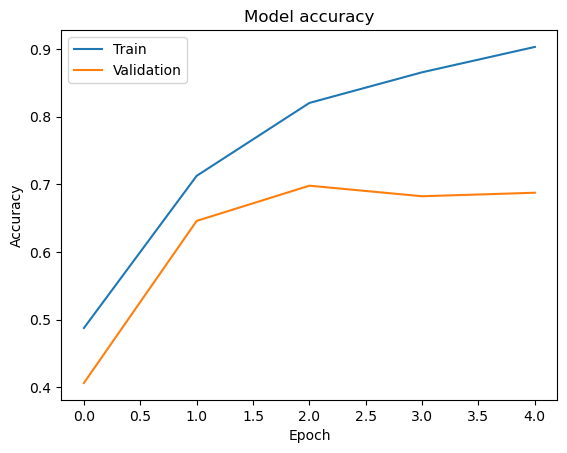

In [58]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [60]:
model6.evaluate(test_dataset)

13/13 [==============================] - 36s 3s/step - loss: 0.6672 - accuracy: 0.7600


[0.6671839952468872, 0.7599999904632568]

**Model Loss:** <br>
- The training loss continues to decrease steadily, showing that the model is learning well from the training data.
- The validation loss decreases initially and then begins to increase after around 2.5 epochs, which is typical behavior indicating that the model might be starting to overfit. However, the upward trend is more gradual than in previous iterations, suggesting that the regularization and dropout adjustments are having a positive effect.

**Model Accuracy:** <br>
- The training accuracy continues to rise, reflecting the decreasing training loss.
- The validation accuracy has increased to 0.76, which is the highest observed so far. This suggests that the balance between regularization and dropout is improving the model’s ability to generalize.

### L2 = 0.06, Early Stopping patience = 2, LR = 3e-5. + reduce_lr, dropout=0.37 Accuracy -> 0.765

In [67]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

#  if it helps further reduce overfitting
model7 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4,
                                                              dropout=0.37, attention_dropout=0.37)  # adjust to 0.37 from 0.35
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

regularizer = tf.keras.regularizers.l2(l=0.06) # returning to 0.06
for layer in model7.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
            
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

model7.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [69]:
history7 = model7.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping_callback, reduce_lr]
)

Epoch 1/10
80/80 [==============================] - 318s 4s/step - loss: 1.2396 - accuracy: 0.4203 - val_loss: 0.9238 - val_accuracy: 0.6615 - lr: 3.0000e-05
Epoch 2/10
80/80 [==============================] - 361s 5s/step - loss: 0.7523 - accuracy: 0.7391 - val_loss: 0.8450 - val_accuracy: 0.6615 - lr: 3.0000e-05
Epoch 3/10
80/80 [==============================] - 378s 5s/step - loss: 0.5212 - accuracy: 0.8156 - val_loss: 0.8709 - val_accuracy: 0.6615 - lr: 3.0000e-05
Epoch 4/10
80/80 [==============================] - 422s 5s/step - loss: 0.4209 - accuracy: 0.8484 - val_loss: 0.9415 - val_accuracy: 0.6667 - lr: 3.0000e-05


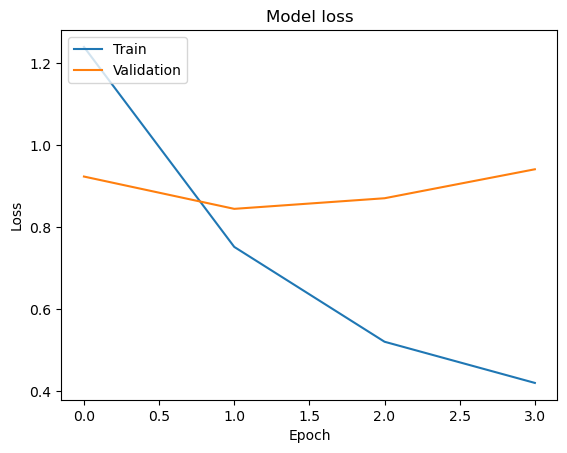

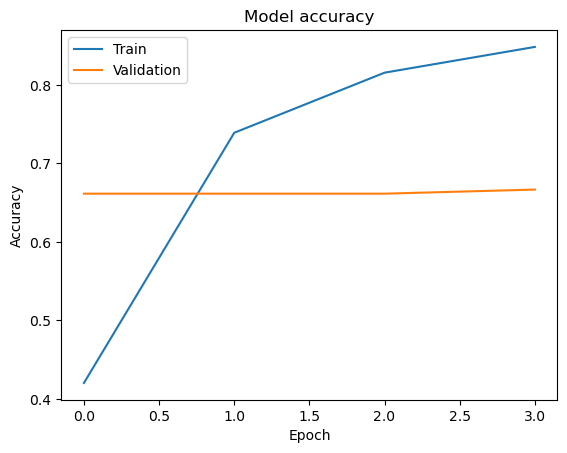

In [70]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [72]:
model7.evaluate(test_dataset)

13/13 [==============================] - 39s 3s/step - loss: 0.6759 - accuracy: 0.7650


[0.6759172677993774, 0.7649999856948853]

**Model Loss:** <br>
- The training loss continues to decrease steadily, showing that the model is effectively learning from the training data.
- The validation loss shows a slight upward trend after the second epoch, indicating that overfitting might still be occurring, but it is controlled and more gradual than in previous iterations.

**Model Accuracy:** <br>
- The training accuracy continues to rise as the model becomes better at predicting the training data.
- The validation accuracy has slightly improved to 0.765, which is the best performance observed so far. This suggests that the model is now generalizing better on the validation data.